***
***

# **COVID-19 Vaccination Progress**

## *7) Triple Exponential Smoothing (Daily Vaccinations)*

***
***

## Table of Contents

| 1. INTRODUCTION | 2. Visualisations | 3. SUMMARY |
|----|----|----|
| *1.1 Dataset Characteristics* | *2.1 Importing Libraries and Data* | 3.1 Key Findings |
| | *2.2 Holt-Winters Model* | 3.2 Next Steps |

***
***

## 1. INTRODUCTION

In this notebook we use the time series datasets (original annd detrended) generated in notebook 6 (Feature Selection for Prediction and Time Series Specific EDA) in Holt-Winter's Exponential smoothing.

***

### 1.1 Dataset Characteristics

1) Our 3 timeseries (Worldwide, Germany & Israel) contain the following:

| FEATURE | description | comment |
|----|----|----|
| **date** | data entry (13th December 2020 to 24th March 2021) | - |
| **daily_vaccinations_raw** | daily vaccinations as CHANGE COMPARED TO PREVIOUS DAY | calculation: total_vaccinations |
***
***

## 2. IMPORTS AND DATA PREPARATION

***

### 2.1 Importing Libraries and Data

+ Import numpy (linear algebra), pandas (data processing), Holt-Winter's exponential Smoothing (statsmodels) and metric calulations (sklearn).
+ Import datasets on COVID-19 vaccination progress from notebook 6.

In [1]:
#Import basic libraries
import numpy as np #Linear algebra
import pandas as pd #Data processing

#Import library for exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

#Import metrics calculation
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

#Suppress pandas future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
#Import datasets
#Worldwide - daily vaccinations (raw)
df_wrld = pd.read_csv('data/df_wrld.csv', parse_dates=['date'])
df_wrld.sort_values('date', inplace=True)
df_wrld = df_wrld.set_index('date')

#Germany -  daily vaccinations (raw)
df_ger = pd.read_csv('data/df_ger.csv', parse_dates=['date'])
df_ger.sort_values('date', inplace=True)
df_ger = df_ger.set_index('date')

#Israel -  daily vaccinations (raw)
df_isr = pd.read_csv('data/df_isr.csv', parse_dates=['date'])
df_isr.sort_values('date', inplace=True)
df_isr = df_isr.set_index('date')

***

### 2.1 Holt-Winters Model

In this section we investigate triple exponential smoothing for 3 timeseries (daily_vaccinations_raw --- worldwide, Germany, Israel). The Holt-Winters model deals with three aspects of a timeseries, namely a typical value (average), a slope over time (trend), and a cyclical repeating pattern (seasonality) expressed as three types of exponential smoothing. Compared to the simple moving average where the past observations are weighted equally, Hot-Winters uses exponential functions to assign exponentially decreasing weights over time thus capturing the underlying patterns very well.

#### **TASK 1**: Worldwide Daily Vaccinations (raw)

1) Split data into train and test
2) Train model and predict
3) Visualise results
4) Evaluation metrics

**KEY FINDINGS**

1) Since there are only few datapoints (102) available at this point in time due to vaccination only having started in December 2020 we will only take a very small set (10 days) for testing. Advantageously fresh data is being generated continuously and we can later test out models on newer data (April 2021).
2) Sometimes there are some missing values right at the start or end of the timeseries, due to vaccinations not having started at the same time in all countries and due to data being reported with a slight delay (i.e. not all countries having reported data for the last day, i.e. 24th March 2021). In addition, as in this case the number to strat of with might be zero and hence needs to be dropped for the model.
3) For training the model the frequency and seasonal periods were easy to include, i.e. daily and 7. However the trend ans seasonal components were more difficult to assign as it was not obvious whether we have constant change or not. Testing different parameters amd comparing by root mean squared error let to trend='mul' and seasonal='add' as the best parameters in this case.
4) The plots show clearly that the exponential smooothing captures the general trend and seasonality reasonably well considering the low number of datapoints and hence seasons.

In [3]:
#Split data into train and test set
df_train, df_test = df_wrld[:'2021-03-14'].reset_index(), df_wrld['2021-03-15':].reset_index()

#Check the number of records in train and test
print(df_train.shape, df_test.shape)

(92, 2) (10, 2)


In [4]:
#Set date as index
df_train = df_train.set_index('date')
df_test = df_test.set_index('date')

#Drop any rows that contain zeros or are empty at the beginning of the series (i.e. in train)
df_train.replace([0], np.nan, inplace=True)
df_train.dropna(inplace=True)

In [5]:
#Holt-Winter's Exponential Smoothing model
#Set daily frequency and weekly seasonality
model = ExponentialSmoothing(df_train, trend='mul', seasonal='add', seasonal_periods=7, freq='D').fit()

#Predict for the next 10 days
test_pred = model.forecast(10)

In [6]:
#Check predicted values
df_check = df_test.daily_vaccinations_raw.to_frame().join(test_pred.to_frame())
df_check.tail(10)

,daily_vaccinations_raw,0
date,,
2021-03-15,8580569.0,7.416701e+06
2021-03-16,7697723.0,7.899536e+06
2021-03-17,8621796.0,9.148123e+06
2021-03-18,9232608.0,9.754187e+06
2021-03-19,10122329.0,1.138087e+07
2021-03-20,9375708.0,1.069198e+07
2021-03-21,5478997.0,6.672937e+06
2021-03-22,11297560.0,8.989694e+06
2021-03-23,12236425.0,9.501354e+06


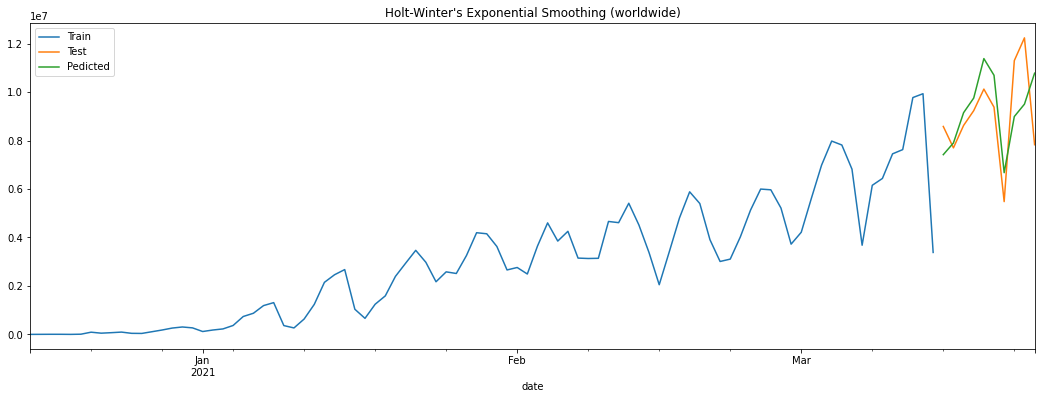

In [7]:
#Plot train, test and predicted values
df_train.daily_vaccinations_raw.plot(legend=True, label='Train', title="Holt-Winter's Exponential Smoothing (worldwide)", figsize=(18,6))
df_test.daily_vaccinations_raw.plot(legend=True, label='Test')
test_pred.plot(legend=True, label='Pedicted');

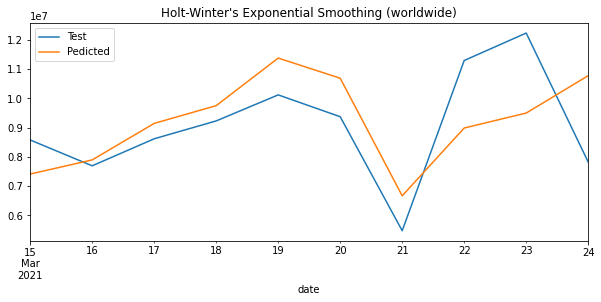

In [8]:
#Plot only test and predicted values
df_test.daily_vaccinations_raw.plot(legend=True, label='Test', title="Holt-Winter's Exponential Smoothing (worldwide)", figsize=(10,4))
test_pred.plot(legend=True, label='Pedicted');

In [9]:
#Evaluation metrics for HW exponential smoothing model
mae = mean_absolute_error(df_test.daily_vaccinations_raw, test_pred)
rmse = mean_squared_error(df_test.daily_vaccinations_raw, test_pred, squared=False)
mape = mean_absolute_percentage_error(df_test.daily_vaccinations_raw, test_pred)

print('====='*10)
print(f'The metrics for the global Holt-Winter model are:')
print('====='*10)
print(f'MAE score: {round(mae,2)}')
print(f'RMSE score: {round(rmse,2)}')
print(f'MAPE score: {round(mape,2)}')
print('====='*10)

The metrics for the global Holt-Winter model are:
MAE score: 1417800.47
RMSE score: 1679638.39
MAPE score: 0.16


#### **TASK 2**: Daily Vaccinations (raw) (Germany)

1) Split data into train and test
2) Train model and predict
3) Visualise results
4) Evaluation metrics

**KEY FINDINGS**

1) Kept last 9 days for testing, since no data for 24th March at this point in time.
2) Dropped entries with zeros at the start of the series, and the entry for 24th March, as it had not been reported yet.
3) For training the model the frequency and seasonal periods were easy to include, i.e. daily and 7. However the trend ans seasonal components were more difficult to assign as it was not obvious whether we have constant change or not. Testing different parameters amd comparing by root mean squared error let to trend='add' and seasonal='add' as the best parameters in this case.
4) The plots show that the exponential smoothing captures the general trend and seasonality reasonably well. However, the large number of unexpected/unforeseeable events currently affecting the process is clearly shown in the test set of the data and thus prediction is relatively poor in this case. NOTE: We need to view the mean absolute percentage error with some caution in this case, since all predicted values are below the actual test values.

In [10]:
#Split data into train and test set
df_train, df_test = df_ger[:'2021-03-14'].reset_index(), df_ger['2021-03-15':].reset_index()

#Check the number of records in train and test
print(df_train.shape, df_test.shape)

(92, 2) (10, 2)


In [11]:
#Set date as index
df_train = df_train.set_index('date')
df_test = df_test.set_index('date')

#Drop any rows that contain zeros or are empty at the beginning of the series (i.e. in train)
df_train.replace([0], np.nan, inplace=True)
df_train.dropna(inplace=True)

#Drop any rows that contain zeros or are empty at the very end of the series (i.e. in test)
df_test.replace([0], np.nan, inplace=True)
df_test.dropna(inplace=True)

In [12]:
#Holt-Winter's Exponential Smoothing model
#Set daily frequency and weekly seasonality
model = ExponentialSmoothing(df_train, trend='add', seasonal='add', seasonal_periods=7, freq='D').fit()

#Predict for the next 9 days only (since no data for 24th March)
test_pred = model.forecast(9)

In [13]:
#Check predicted values
df_check = df_test.daily_vaccinations_raw_germany.to_frame().join(test_pred.to_frame())
df_check.tail(9)

,daily_vaccinations_raw_germany,0
date,,
2021-03-15,234063.0,263962.522337
2021-03-16,177909.0,277590.478608
2021-03-17,208570.0,298922.248835
2021-03-18,189173.0,295799.561340
2021-03-19,228125.0,301446.258932
2021-03-20,206690.0,235608.722988
2021-03-21,164604.0,198385.704179
2021-03-22,260116.0,279714.883253
2021-03-23,268295.0,293342.839525


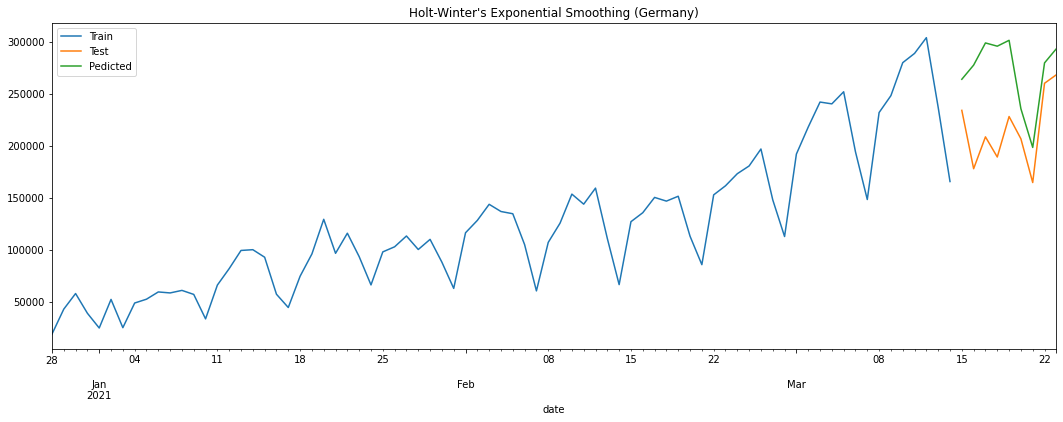

In [14]:
#Plot train, test and predicted values
df_train.daily_vaccinations_raw_germany.plot(legend=True, label='Train', title="Holt-Winter's Exponential Smoothing (Germany)", figsize=(18,6))
df_test.daily_vaccinations_raw_germany.plot(legend=True, label='Test')
test_pred.plot(legend=True, label='Pedicted');

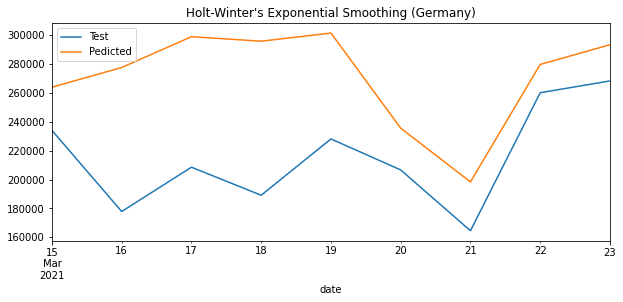

In [15]:
#Plot only test and predicted values
df_test.daily_vaccinations_raw_germany.plot(legend=True, label='Test', title="Holt-Winter's Exponential Smoothing (Germany)", figsize=(10,4))
test_pred.plot(legend=True, label='Pedicted');

In [16]:
#Evaluation metrics for HW exponential smoothing model
mae = mean_absolute_error(df_test.daily_vaccinations_raw_germany, test_pred)
rmse = mean_squared_error(df_test.daily_vaccinations_raw_germany, test_pred, squared=False)
mape = mean_absolute_percentage_error(df_test.daily_vaccinations_raw_germany, test_pred)

print('====='*10)
print(f'The metrics for the Holt-Winter model for Germany are:')
print('====='*10)
print(f'MAE score: {round(mae,2)}')
print(f'RMSE score: {round(rmse,2)}')
print(f'MAPE score: {round(mape,2)}')
print('====='*10)

The metrics for the Holt-Winter model for Germany are:
MAE score: 56358.69
RMSE score: 65598.23
MAPE score: 0.28


#### **TASK 3**: Daily Vaccinations (raw) (Israel)

1) Split data into train and test
2) Train model and predict
3) Visualise results
4) Evaluation metrics

**KEY FINDINGS**

1) Kept last 9 days for testing, since no data for 24th March at this point in time.
2) Dropped entries with zeros at the start of the series, and the entry for 24th March, as it had not been reported yet.
3) For training the model the frequency and seasonal periods were easy to include, i.e. daily and 7. However the trend and seasonal components were more difficult to assign as it was not obvious whether we have constant change or not. Testing different parameters amd comparing by root mean squared error let to trend='mul' and seasonal='mul' as the best parameters in this case.
4) The plots show that the exponential smoothing captures the general trend and seasonality reasonably well. However, the large number of unexpected/unforeseeable events currently affecting the underlying process is clearly reflected in the test set suddendly showing a stronger positive trend than before, which could not be captured verx well.

In [17]:
#Split data into train and test set
df_train, df_test = df_isr[:'2021-03-14'].reset_index(), df_isr['2021-03-15':].reset_index()

#Check the number of records in train and test
print(df_train.shape, df_test.shape)

(92, 2) (10, 2)


In [18]:
#Set date as index
df_train = df_train.set_index('date')
df_test = df_test.set_index('date')

#Drop any rows that contain zeros or are empty at the beginning of the series (i.e. in train)
df_train.replace([np.inf, -np.inf, 0], np.nan, inplace=True)
df_train.dropna(inplace=True)

#Drop any rows that contain zeros or are empty at the very end of the series (i.e. in test)
df_test.replace([np.inf, -np.inf, 0], np.nan, inplace=True)
df_test.dropna(inplace=True)

In [19]:
#Holt-Winter's Exponential Smoothing model
#Set daily frequency and weekly seasonality
model = ExponentialSmoothing(df_train, trend='mul', seasonal='mul', seasonal_periods=7, freq='D').fit()

#Predict for the next 9 days only (since no data for 24th March)
test_pred = model.forecast(9) # no data for 24th March

In [20]:
#Check predicted values
df_check = df_test.daily_vaccinations_raw_israel.to_frame().join(test_pred.to_frame())
df_check.tail(9)

,daily_vaccinations_raw_israel,0
date,,
2021-03-15,440051.0,343523.262216
2021-03-16,529119.0,414565.708918
2021-03-17,581855.0,508850.480092
2021-03-18,660276.0,582693.131474
2021-03-19,740655.0,656353.723935
2021-03-20,844285.0,637897.398625
2021-03-21,419618.0,333992.239204
2021-03-22,412197.0,403799.359871
2021-03-23,494805.0,487307.225734


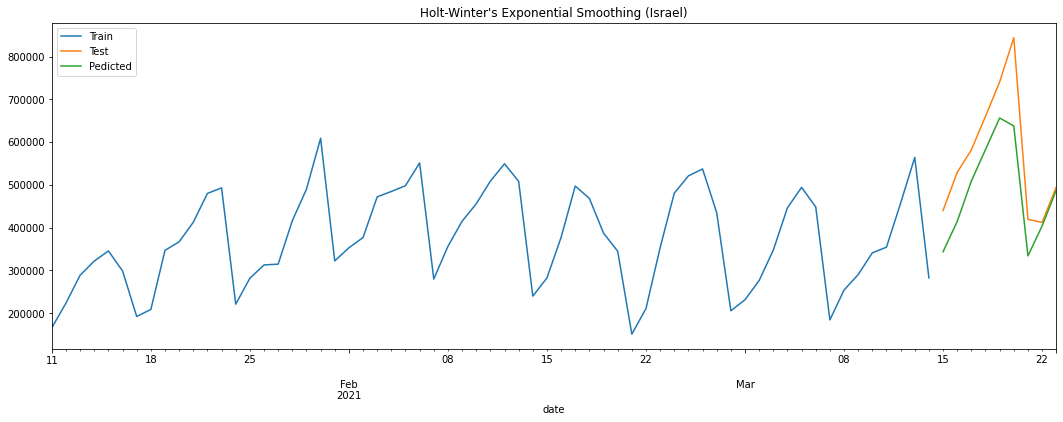

In [21]:
#Plot train, test and predicted values
df_train.daily_vaccinations_raw_israel.plot(legend=True, label='Train', title="Holt-Winter's Exponential Smoothing (Israel)", figsize=(18,6))
df_test.daily_vaccinations_raw_israel.plot(legend=True, label='Test')
test_pred.plot(legend=True, label='Pedicted');

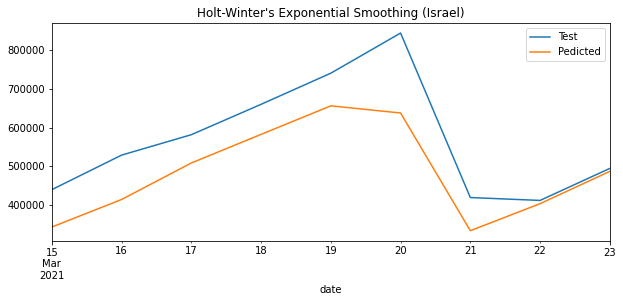

In [22]:
#Plot only test and predicted values
df_test.daily_vaccinations_raw_israel.plot(legend=True, label='Test', title="Holt-Winter's Exponential Smoothing (Israel)", figsize=(10,4))
test_pred.plot(legend=True, label='Pedicted');

In [23]:
#Evaluation metrics for HW exponential smoothing model
mae = mean_absolute_error(df_test.daily_vaccinations_raw_israel, test_pred)
rmse = mean_squared_error(df_test.daily_vaccinations_raw_israel, test_pred, squared=False)
mape = mean_absolute_percentage_error(df_test.daily_vaccinations_raw_israel, test_pred)

print('====='*10)
print(f'The metrics for the Holt-Winter model for Israel are:')
print('====='*10)
print(f'MAE score: {round(mae,2)}')
print(f'RMSE score: {round(rmse,2)}')
print(f'MAPE score: {round(mape,2)}')
print('====='*10)

The metrics for the Holt-Winter model for Israel are:
MAE score: 83764.27
RMSE score: 100526.32
MAPE score: 0.14


***
***

## 3. SUMMARY

***

### 3.1 Key Findings

Holt-Winters exponential smoothing captures the trend and seasonalities of the vaccination process reasonably well, however, of course it cannot predict completely unprecedented events of significant magnitude.
The key metrics used to evaluate the models were RMSE for comparison of the different model and MAE (very useful for data with outliers) and MAPE to get a better feel for the actual deviations and relative error to the data.

***

### 3.2 Next Steps

In the next notebook we will model the 3 timeseries in a SARIMA model, i.e. attempt to model the residual of the detrended series.

***